### Import

In [1]:
import joblib
import datetime

# Preprocessing
import pandas as pd

# Torch-related
import torch
from pytorch_model_summary import summary

# Custom defined
from config import pre_train
from libs.data import load_dataset, collate_fn
from architecture.architecture import *
from architecture.shared_module import patchify

/home/sh-sungho.park/anaconda3/envs/cudatest/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data

In [2]:
is_test_mode = False
is_new_rawdata = False
is_new_dataset = True
config = pre_train
device = torch.device("cuda")
# device = torch.device("cpu")

if is_new_dataset:
    train_dataset = load_dataset(is_test_mode, is_new_rawdata, config, mode="pre_train", verbose=True)
else:
    suffix = "_test" if is_test_mode else ""
    train_dataset = torch.load(f"src/pre_train_dataset{suffix}")

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True, collate_fn=lambda x: collate_fn(x, config), pin_memory=True, num_workers=16, prefetch_factor=32)
# train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True, collate_fn=lambda x: collate_fn(x, config))
for _ in train_dataloader:
    [print(key, val.shape) for key, val in _.items() if "scaler" not in key and "raw" not in key]
    break

100%|██████████| 29274/29274 [00:01<00:00, 20635.73it/s]
/home/sh-sungho.park/anaconda3/envs/cudatest/lib/python3.8/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


sales_encoder_input torch.Size([16, 302, 1])
sales_decoder_input torch.Size([16, 2, 1])
day_encoder_input torch.Size([16, 302])
day_decoder_input torch.Size([16, 2])
dow_encoder_input torch.Size([16, 302])
dow_decoder_input torch.Size([16, 2])
month_encoder_input torch.Size([16, 302])
month_decoder_input torch.Size([16, 2])
holiday_encoder_input torch.Size([16, 302])
holiday_decoder_input torch.Size([16, 2])
price_encoder_input torch.Size([16, 302, 1])
price_decoder_input torch.Size([16, 2, 1])
encoder_input_padding_mask torch.Size([16, 302])
decoder_input_padding_mask torch.Size([16, 2])
img_path torch.Size([16, 3, 224, 224])
detail_desc torch.Size([16, 82])
detail_desc_revert_padding_mask torch.Size([16, 83])
detail_desc_remain_idx torch.Size([16, 21])
detail_desc_masked_idx torch.Size([16, 61])
detail_desc_revert_idx torch.Size([16, 82])
information torch.Size([16, 28])
information_revert_padding_mask torch.Size([16, 29])
information_remain_idx torch.Size([16, 7])
information_masked

Traceback (most recent call last):
  File "/home/sh-sungho.park/anaconda3/envs/cudatest/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/home/sh-sungho.park/anaconda3/envs/cudatest/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/sh-sungho.park/anaconda3/envs/cudatest/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/home/sh-sungho.park/anaconda3/envs/cudatest/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


# Pre-Train

In [3]:
label_encoder_dict = joblib.load("src/label_encoder_dict.pkl")
model = MaskedBlockAutoencoder(config, label_encoder_dict)
model.to(device)
# summary(model, _, device, show_parent_layers=True, print_summary=True)
""

''

In [4]:
import os
from tqdm import tqdm
from collections import defaultdict
from IPython.display import clear_output
from transformers import AutoTokenizer

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

mse_loss = torch.nn.MSELoss(reduction="none")
ce_loss = torch.nn.CrossEntropyLoss(reduction="none")
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")

def get_loss(pred_dict, y_dict, idx_dict, padding_mask_dict):
    loss_dict = {}
    loss_sum, cnt = 0, 0

    for n, (key, pred) in enumerate(pred_dict.items()):
        y = y_dict[key].to(device)

        # Compute loss
        ### Temporal loss
        if key in config.temporal_cols:
            if key in config.scaling_cols:
                loss = mse_loss(pred, y).squeeze()
            elif key in config.embedding_cols:
                loss = ce_loss(pred.view(-1, pred.shape[-1]), y.view(-1).to(torch.long))
                loss = loss.view(y.shape)
        ### Img loss
        elif key in config.img_cols:
            pred = pred[:, 1:, :]
            y = patchify(y, config.patch_size)
            loss = mse_loss(pred, y)
        ### Nlp loss
        elif key in config.nlp_cols:
            pred = pred[:, 1:, :]
            loss = ce_loss(pred.reshape(-1, pred.shape[-1]), y.reshape(-1).to(torch.long))
            loss = loss.view(y.shape)
        
        # Masking loss
        ### Temporal
        if key in config.temporal_cols:
            masked_idx = idx_dict["temporal_masked_idx"]
            masking_mask = (masked_idx==n).sum(dim=-1)
            padding_mask = padding_mask_dict["temporal_padding_mask"]

            total_mask = torch.where((padding_mask==1)&(masking_mask==1), 1, 0)
            loss *= total_mask
            loss_sum += loss.sum(); cnt += total_mask.sum()
            loss = loss.sum()/total_mask.sum()
        ### Img
        elif key in config.img_cols:
            masked_idx = idx_dict[f"{key}_masked_idx"]
            
            loss = torch.gather(loss, index=masked_idx.unsqueeze(-1).expand(-1, -1, loss.shape[-1]), dim=1)
            loss_sum += loss.sum(); cnt += loss.shape[0]*loss.shape[1]*loss.shape[2]
            loss = loss.mean()
        ### Nlp
        elif key in config.nlp_cols:
            masked_idx = idx_dict[f"{key}_masked_idx"]
            padding_mask = padding_mask_dict[f"{key}_masked_padding_mask"][:, 1:]

            loss = torch.gather(loss, index=masked_idx, dim=1)
            loss *= padding_mask

            loss_sum += loss.sum(); cnt += total_mask.sum()
            loss = loss.sum() / padding_mask.sum()
            
        loss_dict[key] = loss
    
    total_loss = loss_sum / cnt
    return loss_dict, total_loss

def obtain_loss_dict_for_plot(total_loss, loss_dict, loss_li_dict, mean_loss_li_dict):
    loss_li_dict["total"].append(total_loss.item())
    mean_loss_li_dict["total"].append(np.array(loss_li_dict["total"]).mean())

    for key, val in loss_dict.items():
        loss_li_dict[key].append(val.item())
        mean_loss_li_dict[key].append(np.array(loss_li_dict[key]).mean())

    return loss_li_dict, mean_loss_li_dict

def plot_sample(nrows, ncols, config, mean_loss_li_dict, output_dict, data_dict, decoding_weight_dict):
    idx, plot_idx = 0, 1
    for key, val in mean_loss_li_dict.items():
        # Individual loss
        plt.subplot(nrows, ncols, plot_idx)
        plt.plot(val)
        plt.title(f"{key}: {val[-1]}")
        plot_idx += 1; 
        if key=="total": 
            plot_idx += 3; continue

        pred, y = output_dict[key].detach().cpu().squeeze(), data_dict[key].squeeze()
        length_dict = {"temporal" if key in config.temporal_cols else key :val.shape[1] for key, val in decoding_weight_dict.items()}
        
        # Temporal sample
        if key in config.temporal_cols:
            ### Sample
            if key in config.embedding_cols: pred = torch.argmax(pred, dim=-1)
            plt.subplot(nrows, ncols, plot_idx)
            plt.plot(y[idx]); plt.plot(pred[idx])
            ### Weight
            decoder_weight = decoding_weight_dict[key][idx].mean(dim=0).detach().cpu()
            # decoder_weight = decoding_weight_dict[key][idx].min(dim=0).values.detach().cpu()
            ###### Temporal
            img_decoder_weight = decoder_weight[length_dict["temporal"]:length_dict["temporal"]+length_dict["img_path"]]
            img_decoder_weight = img_decoder_weight[1:]
            plt.subplot(nrows, ncols, plot_idx+1)
            plt.imshow(img_decoder_weight.reshape(224//config.patch_size, 224//config.patch_size))
            ###### Nlp
            os.environ["TOKENIZERS_PARALLELISM"] = "false"
            nlp_decoder_weight1 = decoder_weight[length_dict["temporal"]+length_dict["img_path"]:length_dict["temporal"]+length_dict["img_path"]+length_dict["detail_desc"]]
            nlp_decoder_weight2 = decoder_weight[length_dict["temporal"]+length_dict["img_path"]+length_dict["detail_desc"]:]
            nlp_decoder_weight = torch.cat([nlp_decoder_weight1[1:], nlp_decoder_weight2[1:]], dim=-1)

            nlp1 = tokenizer.tokenize(tokenizer.decode(data_dict["detail_desc"][idx]))
            nlp2 = tokenizer.tokenize(tokenizer.decode(data_dict["information"][idx]))
            # nlp2 = []
            text = nlp1 + nlp2

            df = pd.DataFrame({"text":text, "weight":nlp_decoder_weight})
            df = df[df["text"]!="[PAD]"]
            plt.subplot(nrows, ncols, plot_idx+2)
            sns.barplot(df["weight"])
            plt.gca().set_xticklabels(df["text"], rotation=90)

        # Img sample
        elif key in config.img_cols:
            pred = unpatchify(pred[:, 1:, :]).permute(0,2,3,1)
            y = y.permute(0,2,3,1)
            
            plt.subplot(nrows, ncols, plot_idx)
            plt.imshow(data_dict["img_path_raw"][idx].permute(1,2,0))

            plt.subplot(nrows, ncols, plot_idx+1)
            plt.imshow(y[idx])

            plt.subplot(nrows, ncols, plot_idx+2)
            plt.imshow(pred[idx])

        # Nlp sample
        elif key in config.nlp_cols:
            pred = tokenizer.decode(torch.argmax(pred, dim=-1)[idx])
            y = tokenizer.decode(y[idx])
        
        plot_idx += 3

    plt.tight_layout()
    plt.show()

def train_epoch(model, optimizer, dataloader, config, e):
    pbar = tqdm(dataloader)
    loss_li_dict, mean_loss_li_dict = defaultdict(list), defaultdict(list)
    model.train()

    for n, data in enumerate(pbar):
        encoder_input = {}
        for key, val in data.items():
            if "encoder_input" in key:
                key = key.replace("_encoder_input", "")
                key = key.replace("encoder_input_", "")
                key = "temporal_padding_mask" if key == "padding_mask" else key
                encoder_input[key] = val
            elif "decoder_input" in key:
                pass
            else:
                encoder_input[key] = val
        data = encoder_input

        optimizer.zero_grad()
        decoding_output_dict, encoding_weight_dict, decoding_weight_dict, idx_dict, padding_mask_dict = model(data, device)
        loss_dict, loss = get_loss(decoding_output_dict, data, idx_dict, padding_mask_dict)
        loss.backward()
        optimizer.step()

        # Plot
        if n % 20 == 0:
            nrows, ncols = 12, 4
            plt.figure(figsize=(25,25))
            clear_output(wait=True)

            loss_li_dict, mean_loss_li_dict = obtain_loss_dict_for_plot(loss, loss_dict, loss_li_dict, mean_loss_li_dict)
            plot_sample(nrows, ncols, config, mean_loss_li_dict, decoding_output_dict, data, decoding_weight_dict)

1==1

True

/tmp/ipykernel_50059/1879720803.py:128: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(df["text"], rotation=90)
/tmp/ipykernel_50059/1879720803.py:128: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(df["text"], rotation=90)
/tmp/ipykernel_50059/1879720803.py:128: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(df["text"], rotation=90)
/tmp/ipykernel_50059/1879720803.py:128: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(df["text"], rotation=90)
/tmp/ipykernel_50059/1879720803.py:128: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(df["text"], rotation=90)
/tmp/ipykernel_50059/1879720803.py:128: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(df["text"], rotat

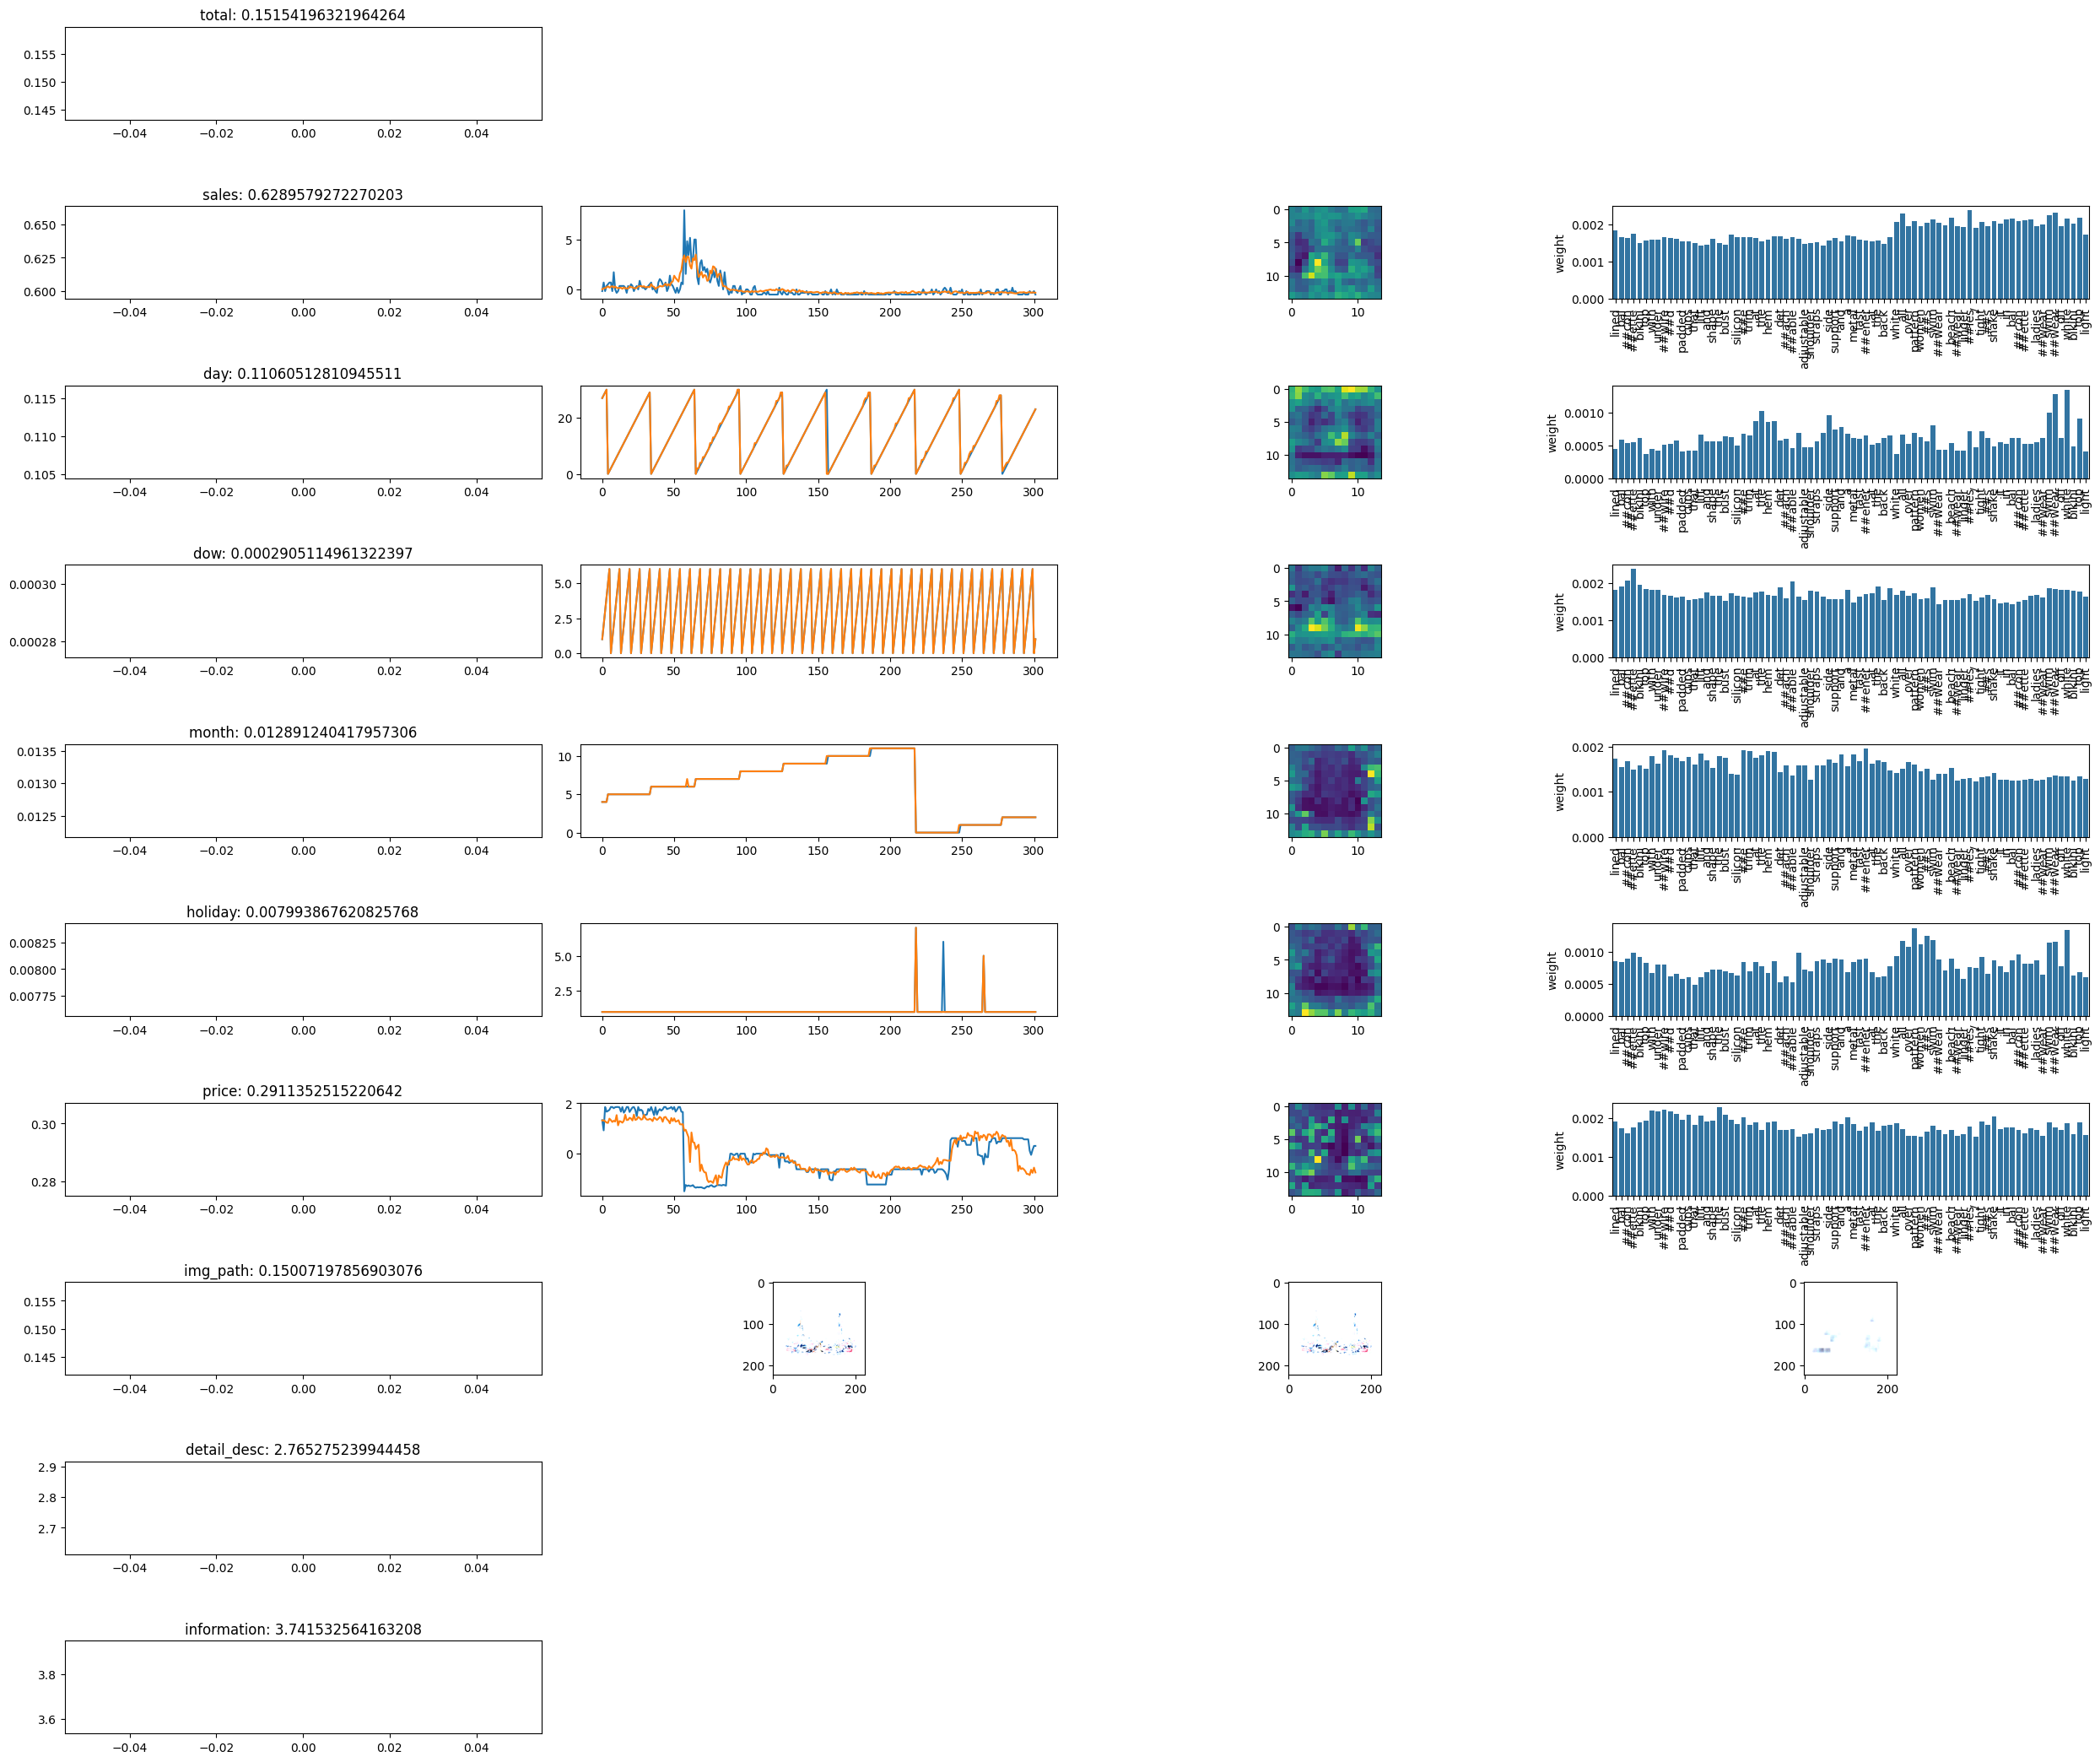

  1%|          | 12/1830 [00:11<12:33,  2.41it/s] 

In [5]:
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)
epoch = 10
 
epoch_loss = {}
for e in range(epoch):
    loss = train_epoch(model, optimizer, train_dataloader, config, e)
    scheduler.step()
    epoch_loss[e] = loss

    # Save model
    if not is_test_mode:
        now = datetime.datetime.now()
        path = f"./saved_model_epoch{e}_{now}"
        torch.save(model.state_dict(), path)

print(epoch_loss)